In [1]:
#@title Define if we are on Colab and mount drive { display-mode: "form" }
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
#@title (COLAB ONLY) Code for setting the environment, installation of packages { display-mode: "form" }
%%capture
if IN_COLAB:
  %env PYTHONPATH=
  !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
  !chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
  !./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
  !conda install --channel defaults conda python=3.6 --yes -q
  !conda update --channel defaults --all --yes -q
  import sys
  sys.path.insert(0, "/usr/local/lib/python3.6/site-packages")

  # !pip install fastai pydicom kornia fastcore==1.0.9 --upgrade --quiet
  !conda config --add channels conda-forge
  !conda install -c fastai -c pytorch fastai fastcore=1.0.9 pydicom gdcm kornia scikit-image scikit-learn pandas numpy ipykernel --yes -q

In [ ]:
#@title (COLAB ONLY) Clone GitHub repo { display-mode: "form" }

if IN_COLAB:
  from getpass import getpass
  user = getpass('GitHub user')
  password = getpass('GitHub password')
  import os
  os.environ['GITHUB_AUTH'] = user + ':' + password
  !git clone https://$GITHUB_AUTH@github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

In [2]:
if IN_COLAB:
  PATH_DRIVER = '/content/gdrive/My Drive/'
  DATA_FOLDER = 'Dataset/'
else:
  PATH_DRIVER = ''
  DATA_FOLDER = 'data/'

In [3]:
import os

from fastai.basics import *
from fastai.vision.all import *
from fastai.medical.imaging import *

In [4]:
filename_prefix = 'IMG_'

PATH_PREFIX = os.path.join(PATH_DRIVER, DATA_FOLDER, '')
raw_folder = PATH_PREFIX + 'DICOMS'
organize_folder = PATH_PREFIX + 'pending_classification'
doubt_folder = PATH_PREFIX + 'doubt'
train_folder = PATH_PREFIX + 'train'

ap_folder = os.path.join(train_folder, 'ap')
lat_folder = os.path.join(train_folder, 'lat')
two_folder = os.path.join(train_folder, 'two')

ap_check_DICOM_dict = {
    'SeriesDescription': ['RODILLA AP'],
    'BodyPartExamined': ['LOWER LIMB', 'KNEE']
}

lat_check_DICOM_dict = {
    'SeriesDescription': ['RODILLA LAT'],
    'BodyPartExamined': ['LOWER LIMB', 'KNEE']
}

two_check_DICOM_dict = {
    'SeriesDescription': ['RODILLAS AP'],
    'BodyPartExamined': ['LOWER LIMB', 'KNEE']
}

In [5]:
raw_fnames = get_files(raw_folder)
n_samples = 50 # None

In [6]:
from utils import check_DICOM
from tqdm import tqdm

# Initialize lists containing the filenames for each class
ap_fnames = []
lat_fnames = []
two_fnames = []

# Open all the files as DICOM and check to which classification have to be placed
for fname in tqdm(raw_fnames, desc='Files: '):
    
    # Read and check DICOM
    dcm = fname.dcmread()
    if check_DICOM(dcm, ap_check_DICOM_dict):
        ap_fnames.append(fname)
    elif check_DICOM(dcm, lat_check_DICOM_dict):
        lat_fnames.append(fname)
    elif check_DICOM(dcm, two_check_DICOM_dict):
        two_fnames.append(fname)

all_folders = [ap_folder, lat_folder, two_folder]
all_fnames = [ap_fnames, lat_fnames, two_fnames]

Files: 100%|██████████| 1738/1738 [00:08&lt;00:00, 215.31it/s]


In [ ]:
from preprocessing import DCMPreprocessDataset

for fnames, folder in zip(all_fnames, all_folders):

    dataset = DCMPreprocessDataset(fnames=fnames, padding_to_square=True, resize=256)
    bins = dataset.init_bins(n_samples=n_samples)
    # dataset.bins = bins

    dataset.save(folder)

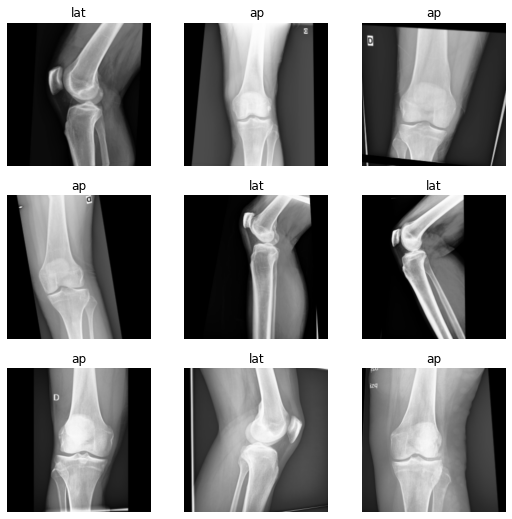

In [7]:
dls = ImageDataLoaders.from_folder(train_folder, valid_pct=0.2, shuffle_train=True, bs=32, batch_tfms=aug_transforms(), num_workers=0)
dls.show_batch()

In [8]:
from fastai.callback import *

# Define the callbacks that will be used during training
callback_fns = [
        MixUp(),
        # partial(OverSamplingCallback),
        # ShowGraph
    ]

learn = cnn_learner(dls, resnet18, metrics=error_rate, callback_fns=callback_fns)

# Regularization by using float precision of 16 bits
# This helps to not overfit because is more difficult to "memorize" images, but enough to learn
learn = learn.to_fp16()

In [ ]:
learn.lr_find()

In [9]:
learn.fine_tune(1, 0.014, freeze_epochs=1)

epoch     train_loss  valid_loss  error_rate  time    
0         0.867569    0.836653    0.148387    00:30     
epoch     train_loss  valid_loss  error_rate  time    
0         0.607165    0.451780    0.067742    00:30     


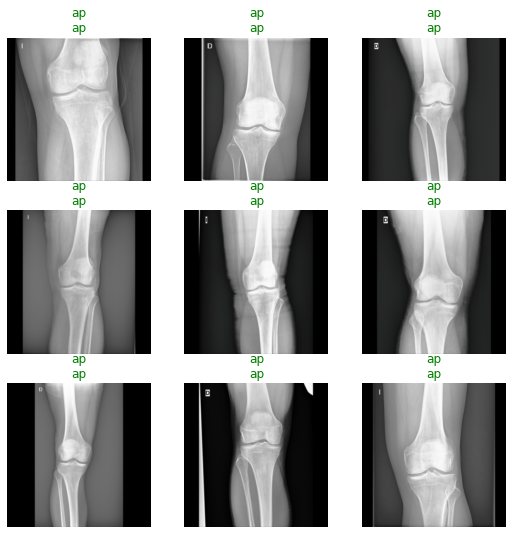

In [10]:
learn.show_results()

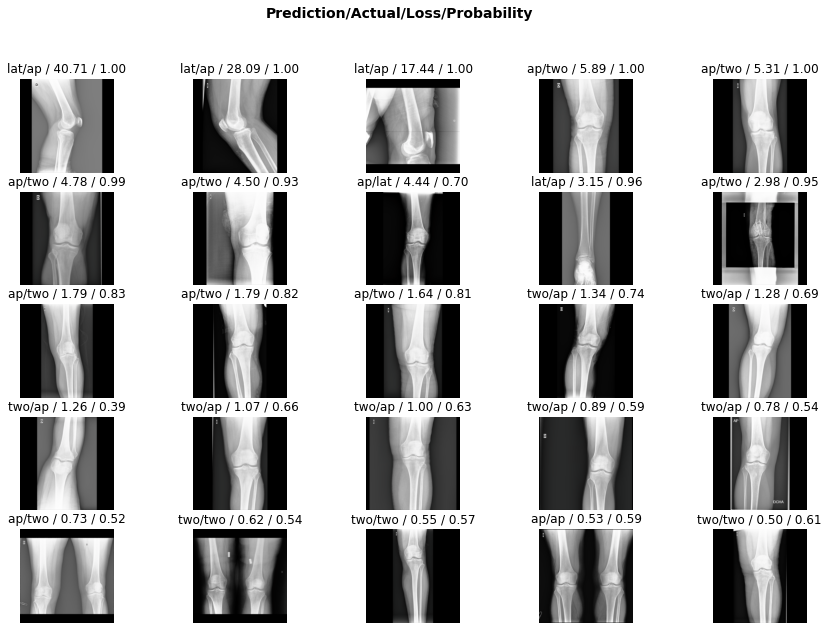

In [11]:
interp = Interpretation.from_learner(learn)
losses, idx = interp.top_losses()
interp.plot_top_losses(25, figsize=(15,10))

In [33]:
w = ImageClassifierCleaner(learn)
w

In [35]:
w.change()

(#3) [(0, &#39;lat&#39;),(1, &#39;lat&#39;),(2, &#39;lat&#39;)]

In [37]:
w.delete()

(#1) [16]

In [ ]:
# preds_train, targs_train = learn.get_preds(0)
# preds_val, targs_val = learn.get_preds(1)
# preds = preds_train + preds_val
# targs = targs_train + targs_val

threshold = 0.8
class_interest = 'ap'

errors = {}
for folder in tqdm(all_folders, desc='Folders: '):
    fnames_png = get_files(folder, extensions='.png')
    label = os.path.split(folder)[-1]

    # for fname in tqdm(fnames_png, desc='Files: ', leave=True, total=len(fnames_png)):
    for fname in fnames_png:
        result = learn.predict(fname)
        pred = result[0]
        prob = result[2][result[1]]
        if label != pred:
            if pred not in errors:
                errors[pred] = {}
                if label not in errors[pred]:
                    errors[pred][label] = [(prob, fname)]
                else:
                    errors[pred][label] += [(prob, fname)]
            else:
                if label not in errors[pred]:
                    errors[pred][label] = [(prob, fname)]
                else:
                    errors[pred][label] += [(prob, fname)]

In [ ]:
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

pretty(errors,0)

In [ ]:
class_interest = 'two'
for pred in errors:
    for label in errors[pred]:
        if pred == class_interest or label == class_interest:
            for prob, fname in errors[pred][label]:
                plt.figure()
                plt.imshow(plt.imread(fname), cmap=plt.cm.bone)
                plt.title(f'{pred}/{label}/{prob:0.4f}')
                plt.show()